In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce

In [2]:
# load data
data_2016 = pd.read_csv('CDS_2016_va.csv')
data_2017 = pd.read_csv('CDS_2017_va.csv')
data_2018 = pd.read_csv('CDS_2018_va.csv')
data_2019 = pd.read_csv('CDS_2019_NO_LABEL.csv')
asignaturas = pd.read_csv('Asignaturas.csv', sep = ';')
clientes = pd.read_csv('Clientes.csv', sep = ';')
cursos = pd.read_csv('Cursos.csv', sep = ';')
lengua = pd.read_csv('Lengua.csv', sep = ';')
tme = pd.read_csv('TME.csv', sep = ';')
ts = pd.read_csv('TS.csv', sep = ';')

In [3]:
# entries in column 'Curso' starts with a 'c' for data_2018
data_2018['Curso'] =  data_2018.Curso.str[1:].astype(int).copy()

# entries in column 'Año natural' are 18 instead of 2018
data_2018['Año natural'] = 2018

# some column labels for data_2016 are different
data_2016.columns = data_2017.columns

# data_2017 has duplicate rows
data_2017.drop_duplicates(subset = None, keep = 'first', inplace = True)

In [4]:
### Asignatura ###

# remove non-numerical values from the asignatura code
asignaturas = asignaturas.loc[~asignaturas.Asignatura.isin(['EE01', '#']),:].copy()

# convert the asignatura code the integer
asignaturas['Asignatura'] = asignaturas.Asignatura.astype(int).copy()

### Curso ###

# remove non-numerical values from the curso code
cursos = cursos.loc[~cursos.Curso.isin(['#']),:].copy()

# convert the curso code the integer
cursos['Curso'] = cursos.Curso.astype(int).copy()

# keep only relevant columns
cursos = cursos[['Curso', 'N_Curso']].copy()

### TME ###

# remove non-numerical values from the curso code
tme = tme.loc[~tme['Tipo Material Educat'].isin(['#']),:].copy()

# convert the curso code the integer
tme['Tipo Material Educativo'] = tme['Tipo Material Educat'].astype(int).copy()

# drop original column
tme.drop('Tipo Material Educat', axis = 1, inplace = True)

### TS ###

# remove non-numerical values from the curso code
ts = ts.loc[~ts['Tipo Soporte Actual'].isin(['#']),:].copy()

# convert the curso code the integer
ts['Tipo Soporte Actual'] = ts['Tipo Soporte Actual'].astype(int).copy()

In [5]:
# create list with all datasets
datasets = [data_2016, data_2017, data_2018, data_2019]

# loop over this list
for i, data in enumerate(datasets):
    
    # join data
    datasets[i] = datasets[i].merge(asignaturas, how = 'left', on = 'Asignatura')
    datasets[i] = datasets[i].merge(clientes, how = 'left', on = 'Id_Cliente')
    datasets[i] = datasets[i].merge(cursos, how = 'left', on = 'Curso')
    datasets[i] = datasets[i].merge(lengua, how = 'left', on = 'Lengua')
    datasets[i] = datasets[i].merge(tme, how = 'left', on = 'Tipo Material Educativo')
    datasets[i] = datasets[i].merge(ts, how = 'left', on = 'Tipo Soporte Actual')
    
    # create a unique record id
    datasets[i]['record_id'] = list(map(lambda a, b, c, d, e, f: str(a) + '_' + \
                                                                 str(b) + '_' + \
                                                                 str(c) + '_' + \
                                                                 str(d) + '_' + \
                                                                 str(e) + '_' + \
                                                                 str(f),
                                        datasets[i]['Id_Cliente'],
                                        datasets[i]['Curso'],
                                        datasets[i]['Asignatura'],
                                        datasets[i]['Tipo Material Educativo'],
                                        datasets[i]['Lengua'],
                                        datasets[i]['Tipo Soporte Actual']))
    
    # create a column for non use, use exception throwing because data_2019 doesn't have the 'Grupo Editorial' column
    try:
        # create column name in the form non_use_YYYY
        column_name = 'non_use_' + str(datasets[i]['Año natural'].unique()[0])
        
        # create binary column with 1 where Grupo Editorial = 90 (non-use)
        datasets[i][column_name] = np.where(datasets[i]['Grupo Editorial'] == 90, 1, 0)
        
    except:
        pass

# merge all four dataframes into one on the record_id
target_df = reduce(lambda x, y: pd.merge(x, y, how = 'outer', on = 'record_id'), datasets)

# keep only the non_use columns and the record_id
target_df = target_df[['record_id', 'non_use_2016', 'non_use_2017', 'non_use_2018']].copy()

# create the target 
target_df['target_2017'] = np.where((target_df.non_use_2016 == 0) & (target_df.non_use_2017 == 1), 1, 0)
target_df['target_2018'] = np.where((target_df.non_use_2017 == 0) & (target_df.non_use_2018 == 1), 1, 0)

# add target to dataframes for 2016 and 2017
datasets[1] = datasets[1].merge(target_df[['record_id', 'target_2017']], how = 'left', on = 'record_id')
datasets[2] = datasets[2].merge(target_df[['record_id', 'target_2018']], how = 'left', on = 'record_id')

# rename columns to allow concatenation on these columns
datasets[0] = datasets[0].rename(columns = {'non_use_2016':'non_use'})
datasets[1] = datasets[1].rename(columns = {'non_use_2017':'non_use', 'target_2017':'target'})
datasets[2] = datasets[2].rename(columns = {'non_use_2018':'non_use', 'target_2018':'target'})

# add column indicating if the record is a non_user in the previous year
datasets[1] = datasets[1].merge(datasets[0][['record_id', 'non_use', 'Grupo Editorial']], 
                                how = 'left', 
                                on = 'record_id', 
                                suffixes = ('', '_previous'))

datasets[2] = datasets[2].merge(datasets[1][['record_id', 'non_use', 'Grupo Editorial']], 
                                how = 'left', 
                                on = 'record_id', 
                                suffixes = ('', '_previous'))

datasets[3] = datasets[3].merge(datasets[2][['record_id', 'non_use', 'Grupo Editorial']], 
                                how = 'left', 
                                on = 'record_id', 
                                suffixes = ('', '_previous'))

# concatenate data into one dataframe
data = pd.concat(datasets, sort = False, ignore_index = True)

# rename columns
data.rename(columns = {'Id_Cliente' : 'client_id', 
                       'Año natural' : 'year', 
                       'Curso' : 'course_code',
                       'Asignatura' : 'subject_code',
                       'Tipo Material Educativo' : 'material_type_code', 
                       'Grupo Editorial' : 'editorial_group', 
                       'Lengua' : 'language_code',
                       'Tipo Soporte Actual' : 'media_support_code',
                       'Variable1' : 'class_size',
                       'Variable2' : 'monetary_value',
                       'N_Asignatura' : 'subject_name',
                       'Latitud' : 'latitude', 
                       'Longitud' : 'longitude', 
                       'Comunidad Autónoma' : 'state', 
                       'Id_Asociación' : 'association_id',
                       'Id_Subasociación' : 'subassociation_id', 
                       'Titularidad' : 'school_type', 
                       'N_Curso' : 'course_name', 
                       'N_Lengua' : 'language_name', 
                       'N_TME' : 'material_type_name',
                       'N_TS' : 'media_support_name',
                       'Grupo Editorial_previous' : 'editorial_group_previous'},
            inplace = True)

# delete unnecessary variables to free up RAM
del asignaturas, clientes, cursos, lengua, tme, ts, data_2016, data_2017, data_2018, data_2019, datasets, target_df

In [6]:
data.head()

,client_id,year,course_code,subject_code,material_type_code,editorial_group,language_code,media_support_code,class_size,monetary_value,...,school_type,course_name,language_name,material_type_name,media_support_name,record_id,non_use,target,non_use_previous,editorial_group_previous
0,113958,2016,27,65,3,31.0,26,1,16.0,70.72,...,Privado,2º Primaria,Euskera,Cuaderno asociado,PAPEL,113958_27_65_3_26_1,0.0,NaN,NaN,NaN
1,113958,2016,27,53,2,31.0,26,1,16.0,288.48,...,Privado,2º Primaria,Euskera,Complementario,PAPEL,113958_27_53_2_26_1,0.0,NaN,NaN,NaN
2,113958,2016,24,79,1,90.0,26,1,8.0,101.52,...,Privado,4 años,Euskera,Básico,PAPEL,113958_24_79_1_26_1,1.0,NaN,NaN,NaN
3,113958,2016,26,53,3,31.0,26,1,36.0,199.08,...,Privado,1º Primaria,Euskera,Cuaderno asociado,PAPEL,113958_26_53_3_26_1,0.0,NaN,NaN,NaN
4,113958,2016,28,48,1,90.0,13,1,22.0,401.06,...,Privado,3º Primaria,Castellano,Básico,PAPEL,113958_28_48_1_13_1,1.0,NaN,NaN,NaN


In [7]:
train = data.loc[(data.year == 2017) | (data.year == 2018),:].copy()

## Categorical Features

In [37]:
train.groupby('client_id').agg(pct_non_use = ('target', 'mean')).describe()

,pct_non_use
count,7927.000000
mean,0.031921
std,0.047484
min,0.000000
25%,0.000000
50%,0.016129
75%,0.044603
max,0.777778


In [8]:
train.groupby('subject_name').agg(pct_non_use = ('target', 'mean'),
                                  count = ('record_id', 'count'))\
                            .sort_values(by = 'count', ascending = False)

,pct_non_use,count
subject_name,,
Inglés,0.021082,183233
Matemáticas,0.027681,119683
Lengua castellana,0.029462,118899
Religión,0.042144,91543
Música,0.035889,85821
...,...,...
App,0.000000,14
Comprensión Lectora,0.000000,13
Áreas integradas - Unidades te,0.153846,13


In [9]:
train.groupby('state').agg(pct_non_use = ('target', 'mean'),
                                  count = ('record_id', 'count'))\
                            .sort_values(by = 'count', ascending = False)

,pct_non_use,count
state,,
Cataluña,0.038015,356230
Comunidad Valenciana,0.030442,316139
Madrid,0.026928,280749
Islas Canarias,0.045614,115557
País Vasco,0.023283,111241
Navarra,0.021869,37725
La Rioja,0.031777,17843


In [10]:
train.groupby('school_type').agg(pct_non_use = ('target', 'mean'),
                                  count = ('record_id', 'count'))\
                            .sort_values(by = 'count', ascending = False)

,pct_non_use,count
school_type,,
Público,0.034543,791210
Católico,0.029993,241290
Privado,0.026657,202984


In [11]:
mapping = {'3 años' : '< 3 años',
               '2 años' : '< 3 años',
               '1 año' : '< 3 años',
               '0 años': '< 3 años'}
    
train.course_name = train.course_name.replace(mapping)

train.groupby('course_name').agg(pct_non_use = ('target', 'mean'),
                                  count = ('record_id', 'count'))\
                            .sort_values(by = 'count', ascending = False)

,pct_non_use,count
course_name,,
3º Primaria,0.033564,115481
4º Primaria,0.031808,114372
5º Primaria,0.032139,114131
6º Primaria,0.032022,112516
2º Primaria,0.038015,111560
1º Primaria,0.038949,110735
4º Secundaria,0.028180,88856
3º Secundaria,0.026166,84232
2º Secundaria,0.025132,72578


In [12]:
train.groupby('language_name').agg(pct_non_use = ('target', 'mean'),
                                  count = ('record_id', 'count'))\
                            .sort_values(by = 'count', ascending = False)

,pct_non_use,count
language_name,,
Castellano,0.031265,808671
Catalán,0.039358,241275
Valenciano,0.031795,110616
Euskera,0.022463,74922


In [13]:
train.groupby('material_type_name').agg(pct_non_use = ('target', 'mean'),
                                  count = ('record_id', 'count'))\
                            .sort_values(by = 'count', ascending = False)

,pct_non_use,count
material_type_name,,
Básico,0.038796,1030486
Cuaderno asociado,0.000000,119954
Complementario,0.000000,71132
Prescribible,0.000000,13912


In [14]:
train.groupby('media_support_name').agg(pct_non_use = ('target', 'mean'),
                                  count = ('record_id', 'count'))\
                            .sort_values(by = 'count', ascending = False)

,pct_non_use,count
media_support_name,,
PAPEL,0.031967,1201538
DIGITAL,0.046220,33946


In [15]:
train.groupby('association_id').agg(pct_non_use = ('target', 'mean'),
                                  count = ('record_id', 'count'))\
                            .sort_values(by = 'count', ascending = False)

,pct_non_use,count
association_id,,
501.0,0.027488,15134
106.0,0.039080,12385
665.0,0.016536,12095
126.0,0.033476,9828
132.0,0.027976,9401
...,...,...
374.0,0.000000,24
392.0,0.000000,22
594.0,0.000000,16


In [16]:
train.association_id.nunique()

265

In [60]:
train.groupby('association_id').agg(associations = ('subassociation_id', 'unique')).values

array([[array([109.])],
       [array([95., 78.])],
       [array([25.])],
       [array([79.])],
       [array([121.])],
       [array([25.])],
       [array([128.,  60., 127., 135.])],
       [array([109.])],
       [array([25.])],
       [array([105.])],
       [array([85.])],
       [array([25.])],
       [array([13.])],
       [array([25.])],
       [array([109.])],
       [array([ 75.,  41., 147.])],
       [array([25.])],
       [array([119.])],
       [array([67.])],
       [array([64.])],
       [array([ 19.,   8.,  49., 116.])],
       [array([25.])],
       [array([46., 19., 37.])],
       [array([109.])],
       [array([25.])],
       [array([ 5., 27., 51., 26., 50.])],
       [array([ 97.,  67.,  58., 122.])],
       [array([25.])],
       [array([109.])],
       [array([109.])],
       [array([75., 40.])],
       [array([13.])],
       [array([25.])],
       [array([25.])],
       [array([109.])],
       [array([ 14., 102., 101.,  59.])],
       [array([107.])],
       [a

In [18]:
train.subassociation_id.nunique()

70

In [19]:
train.groupby('subassociation_id').agg(pct_non_use = ('target', 'mean'),
                                  count = ('record_id', 'count'))\
                            .sort_values(by = 'count', ascending = False)

,pct_non_use,count
subassociation_id,,
109.0,0.028727,149197
25.0,0.033422,27587
13.0,0.027780,27358
19.0,0.037085,14669
100.0,0.025836,4335
...,...,...
140.0,0.029412,170
84.0,0.000000,158
147.0,0.024000,125


## Numerical Columns

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1235484 entries, 612727 to 1848210
Data columns (total 26 columns):
client_id                   1235484 non-null int64
year                        1235484 non-null int64
course_code                 1235484 non-null int64
subject_code                1235484 non-null int64
material_type_code          1235484 non-null int64
editorial_group             1235484 non-null float64
language_code               1235484 non-null int64
media_support_code          1235484 non-null int64
class_size                  1235484 non-null float64
monetary_value              1235484 non-null float64
subject_name                1235405 non-null object
latitude                    1235484 non-null float64
longitude                   1235484 non-null float64
state                       1235484 non-null object
association_id              302379 non-null float64
subassociation_id           302379 non-null float64
school_type                 1235484 non-null object


In [21]:
train[['class_size', 'monetary_value', 'longitude', 'latitude']].describe()

,class_size,monetary_value,longitude,latitude
count,1.235484e+06,1.235484e+06,1.235484e+06,1.235484e+06
mean,4.487495e+01,9.624267e+02,-2.182946e+00,3.962434e+01
std,3.682261e+01,9.114943e+02,4.911727e+00,3.867570e+00
min,0.000000e+00,0.000000e+00,-1.800816e+01,2.764251e+01
25%,2.100000e+01,3.790000e+02,-3.655464e+00,3.946443e+01
50%,3.600000e+01,7.155200e+02,-6.747560e-01,4.045245e+01
75%,5.700000e+01,1.291610e+03,1.213287e+00,4.154693e+01
max,1.540000e+03,3.461744e+04,3.280878e+00,4.342480e+01


### Class Size

In [22]:
train.class_size.max()

1540.0

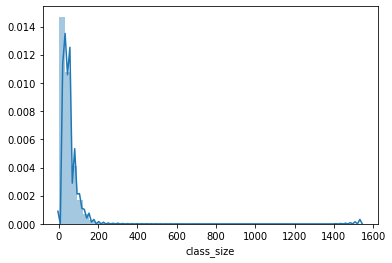

In [23]:
sns.distplot(train.class_size)

In [24]:
train.loc[train.class_size > 200,:]

,client_id,year,course_code,subject_code,material_type_code,editorial_group,language_code,media_support_code,class_size,monetary_value,...,school_type,course_name,language_name,material_type_name,media_support_name,record_id,non_use,target,non_use_previous,editorial_group_previous
612828,113956,2017,36,48,1,15.0,13,1,236.0,7009.20,...,Católico,1º Bachillerato,Castellano,Básico,PAPEL,113956_36_48_1_13_1,0.0,0.0,NaN,NaN
612834,113956,2017,36,54,1,2.0,13,1,236.0,8344.96,...,Católico,1º Bachillerato,Castellano,Básico,PAPEL,113956_36_54_1_13_1,0.0,0.0,NaN,NaN
612855,113956,2017,36,48,3,15.0,13,1,236.0,3407.84,...,Católico,1º Bachillerato,Castellano,Cuaderno asociado,PAPEL,113956_36_48_3_13_1,0.0,0.0,NaN,NaN
612873,113956,2017,37,50,1,2.0,13,1,218.0,8209.88,...,Católico,2º Bachillerato,Castellano,Básico,PAPEL,113956_37_50_1_13_1,0.0,0.0,NaN,NaN
613012,113960,2017,24,63,1,6.0,26,1,207.0,6721.29,...,Católico,4 años,Euskera,Básico,PAPEL,113960_24_63_1_26_1,0.0,0.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847626,212528,2018,27,54,3,6.0,13,1,219.0,963.60,...,Católico,2º Primaria,Castellano,Cuaderno asociado,PAPEL,212528_27_54_3_13_1,0.0,0.0,NaN,NaN
1847630,212528,2018,25,60,2,6.0,13,1,204.0,2392.92,...,Católico,5 años,Castellano,Complementario,PAPEL,212528_25_60_2_13_1,0.0,0.0,NaN,NaN
1847642,212528,2018,25,63,1,6.0,13,1,204.0,6621.84,...,Católico,5 años,Castellano,Básico,PAPEL,212528_25_63_1_13_1,0.0,0.0,NaN,NaN
1847771,212528,2018,23,60,2,6.0,13,1,216.0,1494.72,...,Católico,< 3 años,Castellano,Complementario,PAPEL,212528_23_60_2_13_1,0.0,0.0,NaN,NaN


### Monetary Value

In [25]:
train.monetary_value.max()

34617.44

In [26]:
train.sort_values(by = 'monetary_value', ascending = False)

,client_id,year,course_code,subject_code,material_type_code,editorial_group,language_code,media_support_code,class_size,monetary_value,...,school_type,course_name,language_name,material_type_name,media_support_name,record_id,non_use,target,non_use_previous,editorial_group_previous
1479418,137153,2018,36,48,1,4.0,13,1,979.0,34617.44,...,Público,1º Bachillerato,Castellano,Básico,PAPEL,137153_36_48_1_13_1,0.0,0.0,0.0,4.0
738570,127136,2017,37,43,1,8.0,13,1,884.0,33291.44,...,Público,2º Bachillerato,Castellano,Básico,PAPEL,127136_37_43_1_13_1,0.0,0.0,0.0,2.0
738598,127136,2017,37,54,1,90.0,13,1,884.0,33150.00,...,Público,2º Bachillerato,Castellano,Básico,PAPEL,127136_37_54_1_13_1,1.0,1.0,0.0,34.0
738569,127136,2017,37,35,1,90.0,13,1,884.0,32478.16,...,Público,2º Bachillerato,Castellano,Básico,PAPEL,127136_37_35_1_13_1,1.0,0.0,1.0,90.0
868090,137153,2017,36,48,1,4.0,13,1,979.0,29076.30,...,Público,1º Bachillerato,Castellano,Básico,PAPEL,137153_36_48_1_13_1,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1772920,188942,2018,26,53,3,31.0,26,1,28.0,0.00,...,Público,1º Primaria,Euskera,Cuaderno asociado,PAPEL,188942_26_53_3_26_1,0.0,0.0,0.0,31.0
1606711,168956,2018,30,53,2,3.0,10,1,36.0,0.00,...,Público,5º Primaria,Catalán,Complementario,PAPEL,168956_30_53_2_10_1,0.0,0.0,0.0,3.0
1606697,168956,2018,26,53,3,2.0,10,1,14.0,0.00,...,Público,1º Primaria,Catalán,Cuaderno asociado,PAPEL,168956_26_53_3_10_1,0.0,0.0,NaN,NaN
1772949,188942,2018,30,53,2,31.0,26,1,24.0,0.00,...,Público,5º Primaria,Euskera,Complementario,PAPEL,188942_30_53_2_26_1,0.0,0.0,0.0,31.0


### Geolocation

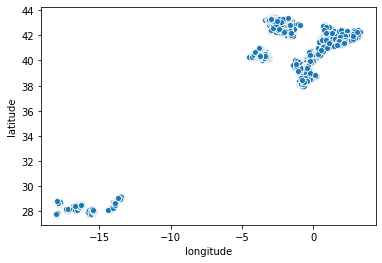

In [27]:
sns.scatterplot(x = 'longitude', y = 'latitude', data = train.sample(frac = 0.05, random_state = 12))

## Merging Data

In [28]:
x = data.loc[data.year == 2017,:].merge(data.loc[data.year == 2016, ['record_id', 'class_size', 'monetary_value', 'association_id', 'subassociation_id']],
                                         on = 'record_id',
                                         suffixes = ('', '_previous'))

In [29]:
x['class_grew'] = np.where(x.class_size > x.class_size_previous, 1, 0)
x['class_shrank'] = np.where(x.class_size < x.class_size_previous, 1, 0)
x['class_same'] = np.where(x.class_size == x.class_size_previous, 1, 0)

In [30]:
x.groupby('class_same').agg(pct_non_use = ('target', 'mean'),
                                  count = ('record_id', 'count'))\
                            .sort_values(by = 'count', ascending = False)

,pct_non_use,count
class_same,,
0,0.041899,357477
1,0.039670,155888


In [31]:
(x.subassociation_id.fillna(0) == x.subassociation_id_previous.fillna(0)).mean()

1.0

## Aggregating on School Level

In [32]:
train['kindergarden'] = list(map(lambda x: int('años' in x), train.course_name)) 
train['primary'] = list(map(lambda x: int('Primaria' in x), train.course_name))
train['secondary'] = list(map(lambda x: int('Secundaria' in x), train.course_name))
train['highschool'] = list(map(lambda x: int('Bachillerato' in x), train.course_name)) 

In [33]:
train.groupby('client_id').agg(n_courses = ('course_name', 'nunique'),
                               kindergarden = ('kindergarden', 'max'),
                               primary = ('primary', 'max'),
                               secondary = ('secondary', 'max'),
                               highschool = ('highschool', 'max'),
                               n_subjects = ('subject_name', 'nunique'),
                               n_materials = ('material_type_name', 'nunique'),
                               n_support = ('media_support_name', 'nunique'),
                               sum_class_size = ('class_size', 'sum'),
                               avg_class_size = ('class_size', 'mean'),
                               total_monetary_value = ('monetary_value', 'sum'),
                               avg_non_use_previous = ('non_use_previous', 'mean'))

,n_courses,kindergarden,primary,secondary,highschool,n_subjects,n_materials,n_support,sum_class_size,avg_class_size,total_monetary_value,avg_non_use_previous
client_id,,,,,,,,,,,,
113956,6,0,0,1,1,30,4,2,21097.0,71.758503,514264.80,0.209677
113958,13,1,1,1,0,19,4,1,5963.0,22.759542,117616.55,0.369478
113960,15,1,1,1,1,36,4,2,12074.0,63.547368,256331.86,0.117647
113962,13,1,1,1,0,19,3,2,13610.0,46.609589,273084.12,0.392857
113963,4,0,0,1,0,13,1,2,1323.0,16.961538,23175.61,0.674419
...,...,...,...,...,...,...,...,...,...,...,...,...
212517,10,1,1,1,0,13,4,2,3757.0,46.962500,68377.11,NaN
212528,15,1,1,1,1,38,4,2,10532.0,60.528736,190115.56,NaN
212529,13,1,1,1,0,24,4,1,7944.0,55.552448,158147.10,NaN


In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1235484 entries, 612727 to 1848210
Data columns (total 30 columns):
client_id                   1235484 non-null int64
year                        1235484 non-null int64
course_code                 1235484 non-null int64
subject_code                1235484 non-null int64
material_type_code          1235484 non-null int64
editorial_group             1235484 non-null float64
language_code               1235484 non-null int64
media_support_code          1235484 non-null int64
class_size                  1235484 non-null float64
monetary_value              1235484 non-null float64
subject_name                1235405 non-null object
latitude                    1235484 non-null float64
longitude                   1235484 non-null float64
state                       1235484 non-null object
association_id              302379 non-null float64
subassociation_id           302379 non-null float64
school_type                 1235484 non-null object


In [35]:
data.editorial_group.value_counts()

90.0    738136
3.0     340570
1.0     271096
2.0     196883
4.0     163689
8.0      89122
6.0      84022
10.0     82819
5.0      64245
34.0     61037
18.0     45382
9.0      40536
15.0     35159
19.0     28623
31.0     24926
16.0     20518
13.0     16210
26.0     15736
24.0     15327
40.0      9551
20.0      8644
17.0      6885
30.0      4625
28.0      4564
25.0      2844
22.0      2467
38.0      1652
7.0       1469
39.0      1381
36.0      1371
29.0      1285
35.0      1268
37.0      1155
32.0       679
43.0       570
44.0       275
27.0       212
33.0        39
23.0        38
41.0        37
42.0         2
Name: editorial_group, dtype: int64

In [41]:
train_2017 = train.loc[train.year == 2017,:].copy()

In [42]:
train_2017

,client_id,year,course_code,subject_code,material_type_code,editorial_group,language_code,media_support_code,class_size,monetary_value,...,media_support_name,record_id,non_use,target,non_use_previous,editorial_group_previous,kindergarden,primary,secondary,highschool
612727,113956,2017,35,8,1,3.0,26,1,32.0,881.28,...,PAPEL,113956_35_8_1_26_1,0.0,0.0,NaN,NaN,0,0,1,0
612728,113956,2017,33,40,1,3.0,26,1,81.0,2353.05,...,PAPEL,113956_33_40_1_26_1,0.0,0.0,NaN,NaN,0,0,1,0
612729,113956,2017,32,73,1,90.0,26,1,78.0,1998.36,...,PAPEL,113956_32_73_1_26_1,1.0,0.0,NaN,NaN,0,0,1,0
612730,113956,2017,32,65,3,13.0,26,1,78.0,852.54,...,PAPEL,113956_32_65_3_26_1,0.0,0.0,NaN,NaN,0,0,1,0
612731,113956,2017,32,65,3,13.0,13,1,60.0,655.80,...,PAPEL,113956_32_65_3_13_1,0.0,0.0,NaN,NaN,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228352,211817,2017,23,48,1,34.0,13,1,21.0,295.47,...,PAPEL,211817_23_48_1_13_1,0.0,0.0,NaN,NaN,1,0,0,0
1228353,211817,2017,23,51,2,6.0,13,1,21.0,261.45,...,PAPEL,211817_23_51_2_13_1,0.0,0.0,NaN,NaN,1,0,0,0
1228354,211817,2017,23,243,1,6.0,13,1,10.0,114.60,...,PAPEL,211817_23_243_1_13_1,0.0,0.0,NaN,NaN,1,0,0,0
1228355,211817,2017,24,51,2,6.0,13,1,20.0,265.60,...,PAPEL,211817_24_51_2_13_1,0.0,0.0,NaN,NaN,1,0,0,0


In [47]:
class_size_mean = train_2017.class_size.mean()
class_size_std = train_2017.class_size.std()

lower = 1
upper = class_size_mean + 3 * class_size_std

mask = (train_2017.class_size < lower) | (train_2017.class_size > upper)

train_2017.loc[mask, 'class_size'] = class_size_mean

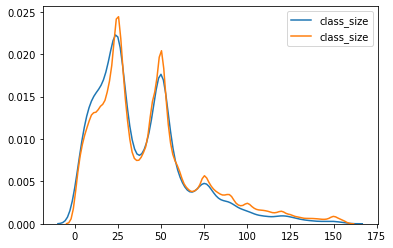

In [55]:
ax = sns.kdeplot(train_2017.loc[train_2017.target == 1, 'class_size'])
ax = sns.kdeplot(train_2017.loc[train_2017.target == 0, 'class_size'])

In [58]:
np.corrcoef(train_2017.monetary_value / train_2017.class_size, train_2017.target)

array([[1.        , 0.01967124],
       [0.01967124, 1.        ]])

In [ ]:
subjects_mapping = {'Biología y geología' : 'Natural Sciences', 'Geografía e historia' : 'Social Sciences', 'Plástica' : 'Other', 'Música' : 'Arts', 'Lengua castellana' : 'Language', 'Religión' : 'Religion', 'Física y química': 'Natural Sciences', 'Lengua autonómica' : 'Language', 'Inglés' : 'Language', 'Tecnología' : 'Natural Sciences', 'Economía' : 'Social Sciences', 'Publicaciones generales' : 'Other', 'Matemáticas' : 'Natural Sciences', 'Informática' : 'Natural Sciences', 'Matemáticas (Ciencias Naturale' : 'Natural Sciences', 'Latín' : 'Language', 'Plan lector' : 'Other', 'Literatura' : 'Language', 'Tecnologia Industrial' : 'Natural Sciences', 'Historia' : 'Social Sciences', 'Historia del arte' : 'Social Sciences', 'Filosofía' : 'Social Sciences', 'Tecnologías de la información' : 'Natural Sciences', 'Dibujo técnico' : 'Natural Sciences', 'Biología' : 'Natural Sciences', 'Física' : 'Natural Sciences', 'Ciencias de la tierra y medio' : 'Natural Sciences', 'Matemáticas (Ciencias Sociales' : 'Natural Sciences', 'Química' : 'Natural Sciences', 'Geografía' : 'Social Sciences', 'Valores sociales y cívicos': 'General Education', 'Áreas integradas' : 'Other', 'Lectoescritura' : 'Language', 'Ciencias de la naturaleza' : 'Natural Sciences', 'Social Science' : 'Social Sciences', 'Music' : 'Arts', 'Diccionarios Escolares' : 'Other', 'Francés' : 'Language', 'Geography and History' : 'Social Sciences', 'Ciencias sociales' : 'Social Sciences', 'Natural Science' : 'Natural Sciences', 'Educación emocional' : 'General Education', 'Biblias escolares' : 'Religious', 'Arts & Crafts' : 'Arts', 'Conocimiento del medio' : 'General Education', 'Proyectos' : 'Other', 'Visual Arts' : 'Arts', 'Cultura clásica' : 'Arts', 'Sciences Naturelles' : 'Natural Sciences', 'Sciences Sociales' : 'Social Sciences', 'Biology and Geology' : 'Natural Sciences', 'Tecnology' : 'Natural Sciences', 'Griego' : 'Language', 'Grafomotricidad' : 'Other', 'Educación para la ciudadanía' : 'General Education', 'Cultura Científica' : 'Natural Sciences', 'Ciencias para el mundo contemp' : 'Natural Sciences', 'PMAR (Técnico)' : 'Natural Sciences', 'Vacaciones' : 'Other', 'Aprendizajes básicos' : 'General Education', 'Competencias básicas' : 'General Education', 'Alternativa Religión' : 'Religious', 'Educación Física' : 'Physical Education', 'PAI' : 'Other', 'Science' : 'Natural Sciences', 'Conviure' : 'Other', 'PAM' : 'Other', 'Inteligencias múltiples' : 'Social Sciences', 'PMAR (Social)' : 'Social Sciences', 'Pastoral' : 'Religious', 'Agenda' : 'Other', 'Áreas integradas - Unidades te' : 'Other', 'Physical Education' : 'Physical Education', 'Comprensión Lectora' : 'Language', 'Proyectos bilingüe' : 'Language', 'Plan lector Loran' : 'Other', 'App' : 'Other', 'Áreas integradas bilingüe': 'Language'}

train.subject_name = train.subject_name.map(subjects_mapping)